# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Florin Barbisch</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [8]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

16384


d:\dev\hpc-m2\.venv\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

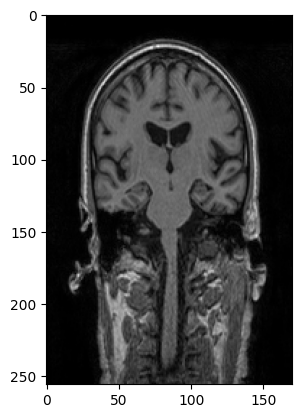

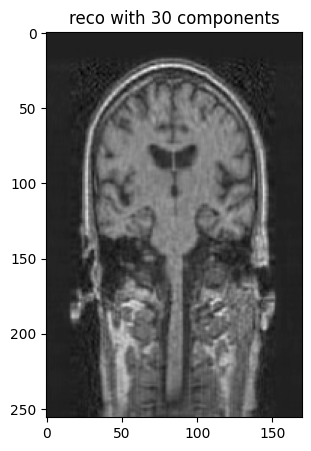

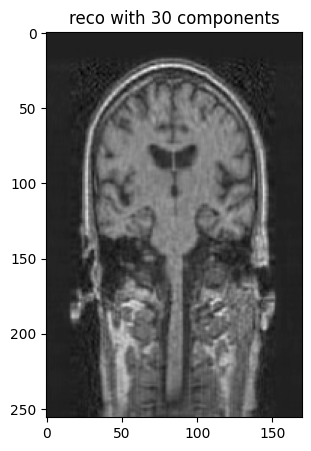

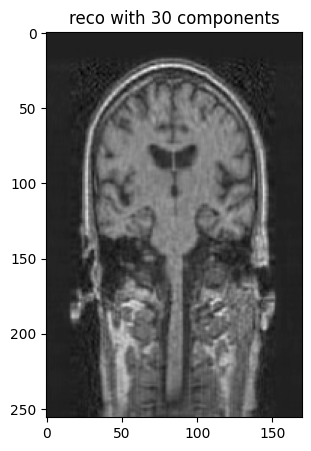

In [9]:
### BEGIN SOLUTION
import imageio.v2 as imageio
import cupy as cp
from cupyx.profiler import benchmark
from numba import cuda, float32

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import queue
import math
import time
import timeit
import random
import pickle
from tqdm import tqdm


image_path = "./adni_png/001/m4-2_slice145.png"
image_brain = imageio.imread(image_path)

plt.imshow(image_brain, cmap='gray')

# normalize data
image_brain = image_brain - image_brain.min() / image_brain.max() - image_brain.min() 

# compute SVD
u,s,vt = np.linalg.svd(image_brain, full_matrices=False)

## helper function to plot reconstructed image
def plot_reco(reco, k):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')


## reconstruct image
k = 30  # Number of components to keep
u_gpu = cp.asarray(u)
s_gpu = cp.asarray(s)
vt_gpu = cp.asarray(vt)


# different variants not using a kernel
def reconstruct_svd_cp(u, s, vt, k):
    return cp.dot(u[:, :k], cp.dot(cp.diag(s[:k]), vt[:k, :]))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    return cp.einsum('ij,j,jk', u[:, :k], s[:k], vt[:k, :])

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    return cp.dot(u[:, :k], cp.multiply(s[:k].reshape(-1, 1), vt[:k, :]))

## validate results by plotting
plot_reco(cp.asnumpy(reconstruct_svd_cp(u_gpu, s_gpu, vt_gpu, k)), k)
plot_reco(cp.asnumpy(reconstruct_svd_cp_einsum(u_gpu, s_gpu, vt_gpu, k)), k)
plot_reco(cp.asnumpy(reconstruct_svd_cp_broadcast(u_gpu, s_gpu, vt_gpu, k)), k)

### END SOLUTION

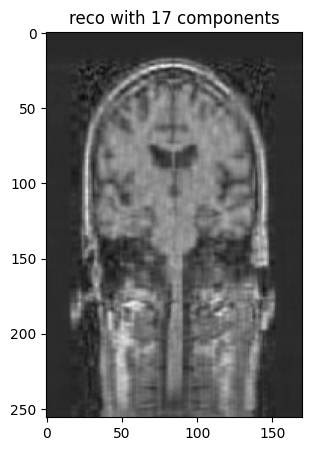

In [10]:
# Kernel implementiert in CUDA C
kernel_code = """
extern "C" __global__
void reconstruct_svd(const float* u, const float* s, const float* vt, float* C,
            int rows_u, int cols_u, int rows_vt, int cols_vt, int k)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    // check if k is in range
    if (k > rows_u || k > cols_vt || k > rows_vt || k > cols_u) {
        return;
    }
    if (k < 0) {
        return;
    }
    // check if i and j are in bounds
    if (i >= rows_u || j >= cols_vt) {
        return;
    }

    float sum = 0;
    for (int l = 0; l < k; ++l) {
        sum += u[i * cols_u + l] * s[l] * vt[l * cols_vt + j];
    }
    C[i * cols_vt + j] = sum;
}
"""

reconstruct_svd_kernel = cp.RawKernel(kernel_code, 'reconstruct_svd')

u, s, vt = np.linalg.svd(image_brain, full_matrices=False)
k = 17

u = u[:, 0:k]
s = s[0:k]
vt = vt[0:k, :]

C = np.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.asarray(C, dtype=np.float32)

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_kernel(blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k))

C = cp.asnumpy(C_gpu)

plot_reco(C, k)

Die Kernelfunktion funktioniert!

In [11]:
# load reconstruction_times.pkl as dataframe
df = pd.read_pickle('reconstruction_times.pkl')
df['cpu'] = True
ks = df['k'].unique()

In [12]:
# measure time

# warmup
reconstruct_svd_kernel(blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k))

# measure kernel time
reconstruction_times_cuda = []
for k in ks:
    elapsed = benchmark(reconstruct_svd_kernel, (blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k)), n_repeat=10).gpu_times.sum()
    reconstruction_times_cuda.append(("reconstruct_svd_kernel", k, elapsed))


cupy_methods = [reconstruct_svd_cp, reconstruct_svd_cp_einsum, reconstruct_svd_cp_broadcast]

for method in cupy_methods:
    # warmup
    method(u_gpu, s_gpu, vt_gpu, k)
    for k in ks:
        elapsed = timeit.timeit(lambda: method(u_gpu, s_gpu, vt_gpu, k), globals=globals(), number=10)
        reconstruction_times_cuda.append((method.__name__, k, elapsed))

reconstruction_times_cuda = pd.DataFrame(reconstruction_times_cuda, columns=['method', 'k', 'time'])
reconstruction_times_cuda['cpu'] = False

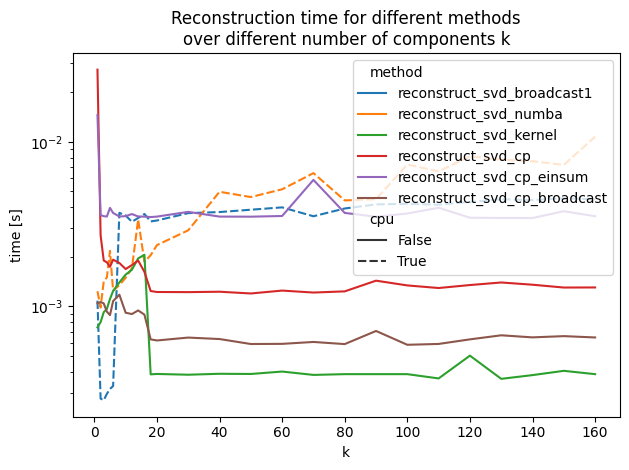

In [13]:
# concatenate times
df = pd.concat([df, reconstruction_times_cuda])

# plot times
sns.lineplot(x="k", y="time", hue="method", style="cpu", data=df[df["method"].isin(["reconstruct_svd_numba", "reconstruct_svd_broadcast1", "reconstruct_svd_kernel", "reconstruct_svd_cp", "reconstruct_svd_cp_einsum", "reconstruct_svd_cp_broadcast"])])
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("time [s]")
plt.title("Reconstruction time for different methods\nover different number of components k")
plt.tight_layout()
plt.show()


Die Aufteilung der Berechnungen auf CPU und GPU ist wie folgt:
- Die CPU schneidet die Matrizen so, dass nur die ersten k Reihen/Spalten verwendet werden.
- Die GPU erledigt die eigentliche GPU-Rekonstruktion.

Ich habe mir die beiden Libraries Cupy und Numba angesehen. Mir sind folgende Unterschiede aufgefallen, wann welche Library verwendet werden kann:
- CuPy:
 - Wenn der Code schon vektorisiert ist (z.B. mit numpy)
 - und ich den Code nicht gross anpassen will (da CuPy ein drop-in replacement für numpy ist)
- Numba:
  - Wenn der Code noch nicht vektorisiert ist (z.B. enthält for loops) und der Code deshalb kompileriert ist.
Da mein Code aus dem ersten Teil schon vektorisiert ist, habe ich mich für CuPy entschieden. Was ich mir aber nicht überlegt habe: Ich muss das ganze in einem Kernel implementieren und das geht in Numba viel einfacher. Deshalb habe ich einen RawKernel in CuPy implementiert (`reconstruct_svd_kernel`) und noch drei varianten aus dem ersten Teil mit Hilfe des drop-in replacements von CuPy implementiert (`reconstruct_svd_cp`, `reconstruct_svd_cp_einsum` und `reconstruct_svd_cp_broadcast`).

Wie in der Grafik oben zu entnehmen ist, sind alle GPU-Varianten nach einem k von so ca. 35 auf einem ADNI-Bild schneller als die CPU_Varianten. Die drop-in replacements von CuPy haben eine konstante Performance (unabhängig von k), während meine Kernel-Funktion eine Performance hat, die mit steigendem k zunimmt. 

#### 5.2 GPU-Kernel Performance

##### 5.3.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [14]:
# create new test matrices
debug = False
if debug:
    test_image_1 = np.random.rand(random.randint( 80, 100), random.randint( 80, 100))
    test_image_2 = np.random.rand(random.randint(200, 250), random.randint(200, 250))
    test_image_3 = np.random.rand(random.randint(400, 450), random.randint(400, 450))
else:
    test_image_1 = np.random.rand(random.randint( 800, 1000), random.randint( 800, 1000))
    test_image_2 = np.random.rand(random.randint(2000, 2500), random.randint(2000, 2500))
    test_image_3 = np.random.rand(random.randint(4000, 4500), random.randint(4000, 4500))
# huge_image = np.random.rand(8192, 8192)

images = {
    'test_image_1': test_image_1,
    'test_image_2': test_image_2,
    'test_image_3': test_image_3,
    # 'huge_image': huge_image
}

decompositions = {}
for name, image in tqdm(images.items()):
    # move image to gpu
    image_gpu = cp.asarray(image, dtype=np.float32)
    u_gpu, s_gpu, vt_gpu = cp.linalg.svd(image_gpu, full_matrices=False)

    u = cp.asnumpy(u_gpu)
    s = cp.asnumpy(s_gpu)
    vt = cp.asnumpy(vt_gpu)

    # release memory
    del u_gpu, s_gpu, vt_gpu, image_gpu

    decompositions[name] = {
        'u': u,
        's': s,
        'vt': vt
    }

100%|██████████| 3/3 [00:30<00:00, 10.11s/it]


In [15]:
# from part 1
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION

    return reco

# add comparison times of CPU reconstruction
cpu_times = []
for name, decomposition in tqdm(decompositions.items()):
    u = decomposition['u']
    s = decomposition['s']
    vt = decomposition['vt']
    
    k = min(u.shape[1], vt.shape[0]) 

    # measure time
    elapsed = timeit.timeit(lambda: reconstruct_svd_broadcast1(u, s, vt, k), globals=globals(), number=10)
    cpu_times.append({
        'name': name,
        'image_size': (u.shape[0], vt.shape[1]),
        'k': k,
        'time': elapsed
    })

cpu_times = pd.DataFrame(cpu_times, columns=['name', 'image_size', 'k', 'time'])
cpu_times

100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


,name,image_size,k,time
0,test_image_1,"(871, 853)",853,0.073578
1,test_image_2,"(2040, 2015)",2015,0.440712
2,test_image_3,"(4106, 4215)",4106,3.732177


In [16]:
block_configurations = []
for i in range(2, 6):
    block_configurations.append((2**i, 2**i))
    block_configurations.append((2**i, 2**(i-1)))
    block_configurations.append((2**(i-1), 2**i))
    block_configurations.append((2**(i-1), 2**(i+1)))
    block_configurations.append((2**(i-2), 2**(i+1)))
    block_configurations.append((2**(i-2), 2**(i+2)))

In [17]:
### BEGIN SOLUTION
def measure_kernel_reconstruction(threads_per_block, decomposed_image):
    u, s, vt = decomposed_image['u'], decomposed_image['s'], decomposed_image['vt']
    k = min(u.shape[1], vt.shape[0]) // 3 # use 1/3 of components

    blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    u_gpu = cp.asarray(u, dtype=np.float32)
    s_gpu = cp.asarray(s, dtype=np.float32)
    vt_gpu = cp.asarray(vt, dtype=np.float32)
    C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

    result = benchmark(reconstruct_svd_kernel, (blocks_per_grid, threads_per_block, (u_gpu, s_gpu, vt_gpu, C_gpu, u.shape[0], u.shape[1], vt.shape[0], vt.shape[1], k)), n_repeat=10)
    return {
                "result": result,
                "image_size": (u.shape[0], vt.shape[1]),
                "k": k,
                "blocks_per_grid": blocks_per_grid,
                "threads_per_block": threads_per_block,
            }

experiment_results = []
for image in decompositions.keys():
    for threads_per_block in block_configurations:
        experiment_results.append(measure_kernel_reconstruction(threads_per_block, decompositions[image]))
### END SOLUTION

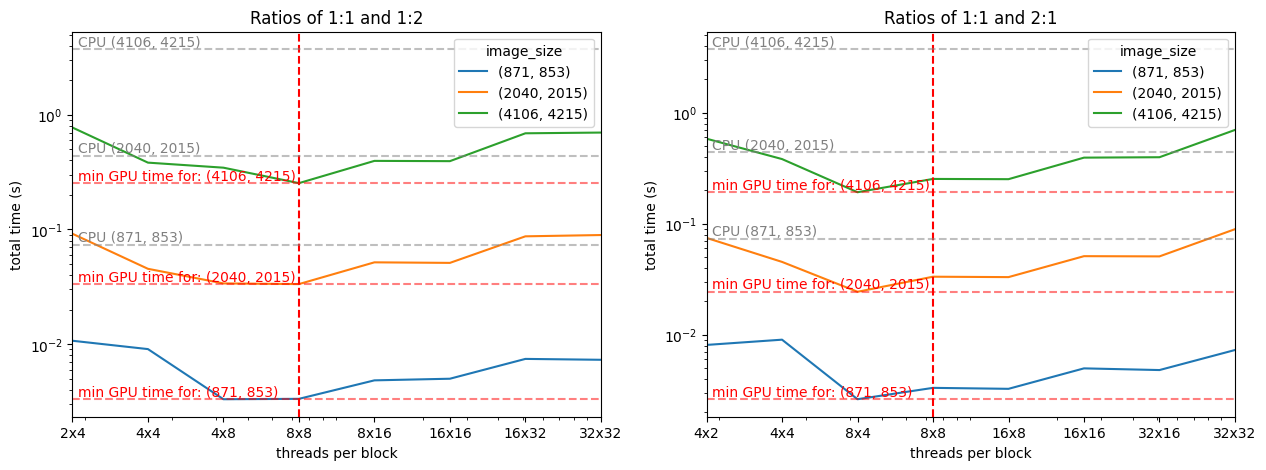

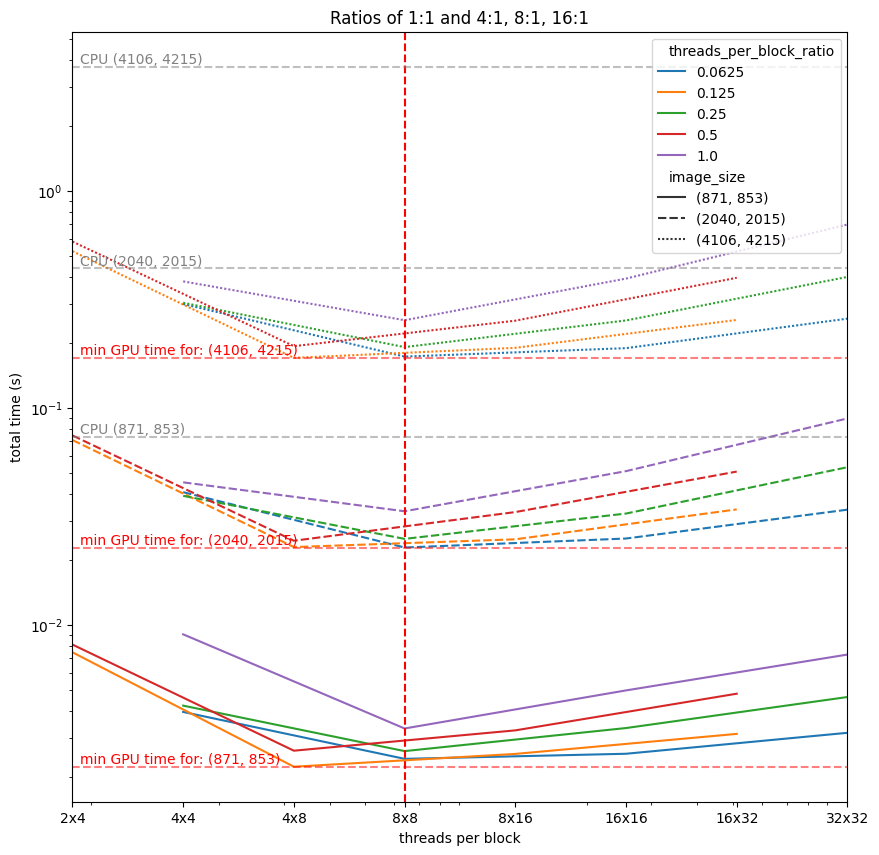

In [26]:
# turn results into dataframe
def convert_experiment_results_to_df(experiment_results):
    df = pd.DataFrame(experiment_results)
    df['gpu_time'] = df['result'].apply(lambda x: x.gpu_times.mean())
    df['cpu_time'] = df['result'].apply(lambda x: x.cpu_times.mean())
    df['total_time'] = df['gpu_time'] + df['cpu_time']
    df['gput_time_std'] = df['result'].apply(lambda x: x.gpu_times.std())
    df['cput_time_std'] = df['result'].apply(lambda x: x.cpu_times.std())
    df['blocks_per_grid_tot'] = df['blocks_per_grid'].apply(lambda x: x[0] * x[1])
    df['blocks_per_grid_str'] = df['blocks_per_grid'].apply(lambda x: f"{x[0]}x{x[1]}")
    df['threads_per_block_ratio'] = df['threads_per_block'].apply(lambda x: x[0] / x[1])
    df['threads_per_block_tot'] = df['threads_per_block'].apply(lambda x: x[0] * x[1])
    df['threads_per_block_str'] = df['threads_per_block'].apply(lambda x: f"{x[0]}x{x[1]}")
    # convert cpu_times to dictionary with image_size as key and time as value
    cpu_time_per_image_size = cpu_times.set_index('image_size')['time'].to_dict()
    df['speedup'] = df.apply(lambda x: cpu_time_per_image_size[x['image_size']] / x['total_time'], axis=1)
    
    df = df.sort_values(by=['gpu_time'])
    return df


def convert_ratios_to_fractions(labels):
    fractions = []
    for label in labels:
        label_num = float(label)
        fractions.append(f"{int(1/label_num)}:1" if label_num < 1 else f"1:{int(label_num)}")
    return fractions


def sub_plot_results(ax, data, title, y="total_time", hue="image_size", style=None, palette=None, ratio=None):
    sns.lineplot(x="threads_per_block_tot", y=y, hue=hue, style=style, palette=palette, data=data, ax=ax)
    # draw a vertical line at 8x8 (64)
    ax.axvline(x=64, color='r', linestyle='--')
    # plot a red horizontal line for the minimal gpu time for each image size
    for image_size in data['image_size'].unique():
        min_gpu_time = data[data['image_size'] == image_size][y].min()
        line = ax.axhline(y=min_gpu_time, color='r', linestyle='--', alpha=0.5)
        # draw text above the line on the left
        ax.text(0.01, min_gpu_time, f"min GPU time for: {image_size}", transform=line.get_transform(), color='r', ha="left", va="bottom")
    # plot a grey horizontal line for the cpu time for each image size
    for image_size in cpu_times['image_size'].unique():
        cpu_time = cpu_times[cpu_times['image_size'] == image_size]['time'].mean()
        line = ax.axhline(y=cpu_time, color='grey', linestyle='--', alpha=0.5)
        # draw text above the line on the left
        ax.text(0.01, cpu_time, f"CPU {image_size}", transform=line.get_transform(), color='grey', ha="left", va="bottom")
    plt.sca(ax)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(8, 1024)
    ticks = [8, 16, 32, 64, 128, 256, 512, 1024]
    if ratio == "1:2":
        labels = ["2x4", "4x4", "4x8", "8x8", "8x16", "16x16", "16x32", "32x32"]
    else:
        labels = ["4x2", "4x4", "8x4", "8x8", "16x8", "16x16", "32x16", "32x32"]
    plt.xticks(ticks, labels)
    plt.xlabel("threads per block")
    plt.ylabel("total time (s)")
    plt.title(title)


df = convert_experiment_results_to_df(experiment_results)

def plot_ratios(df: pd.DataFrame):
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sub_plot_results(ax1, df[df['threads_per_block_ratio'].isin([1, 2])], "Ratios of 1:1 and 1:2", ratio="1:2")
    sub_plot_results(ax2, df[df['threads_per_block_ratio'].isin([1, 0.5])], "Ratios of 1:1 and 2:1")

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sub_plot_results(ax, df[df['threads_per_block_ratio'].isin([1, 0.5, 0.25, 0.125, 0.0625])], "Ratios of 1:1 and 4:1, 8:1, 16:1", hue="threads_per_block_ratio", style="image_size", palette="tab10", ratio="1:2")


plot_ratios(df)

In der obersten Grafik links ist die Performance für die Rekonstruktion mit Blockgrössen im Verhältnis von 1:1 und 1:2 zu sehen. Und in der links mit den Blockgrössen 1:1 und 2:1. Dabei ist zu beobachten, dass in der linken Grafik die beste Performance bei 8x8 liegt, respektive für das kleinste Bild ist die Konfiguration 4x8 am schnellsten. Bei der rechten Grafik ist die beste Performance bei 8x4 überall besser.

Der Speedup gegenüber der CPU beträgt bei allen Konfigurationen ca. 20-30x.

Interessant, dass das Seitenverhältnis der Blöcke einen so grossen Einfluss auf die Performance hat. Deshalb habe ich Blockkonfigurationen mit einem Seitenverhältnis von kleiner als 1 noch genauer untersucht (1:2, 1:4, 1:8, 1:16). Diese Ergebnisse sind in der unteren Grafik zu sehen. Die beste Performance hat die Konfiguration 2x16 über alle Bilder. 

Es macht Sinn, dass in beiden Tests Blockkonfigurationen mit einer Totalen Anzahl an Threads von 32 die beste Performance erreichen, da die NVIDIA GPU in jedem Warp 32 Threads gleichzeitig ausführt. Wenn man mehr Threads pro Block hat, muss CUDA diese Threads auf mehrere Warps aufteilen, was weniger effizient ist.

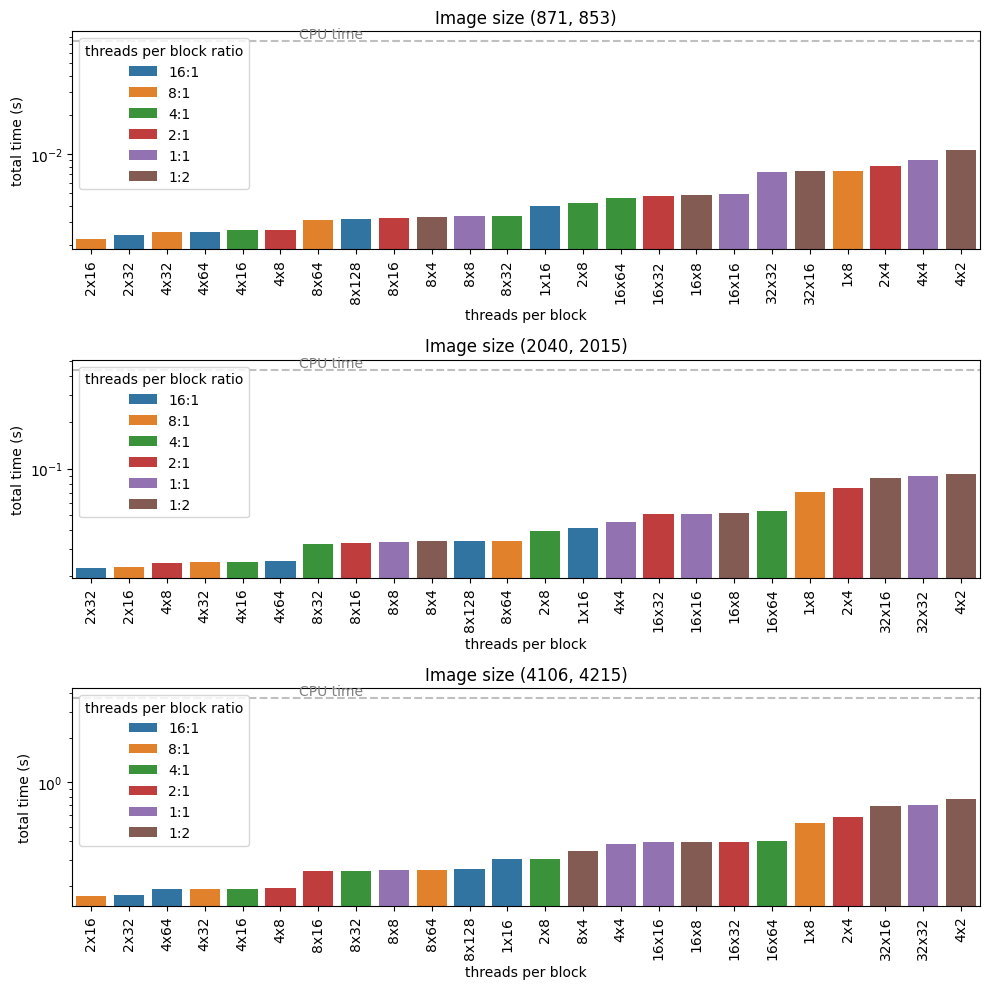

In [37]:
def plot_time_over_ratios(df, include_cpu=True):
    # create three subplots (one for each image size) and plot the results as bar charts with error bars
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    image_sizes = df['image_size'].unique()

    for i, image_size in enumerate(image_sizes):
        ax = axs[i]
        data = df[df['image_size'] == image_size]
        sns.barplot(x="threads_per_block_str", y="total_time", hue="threads_per_block_ratio", data=data, ax=ax, dodge=False)
        ax.set_xlabel("threads per block")
        ax.set_ylabel("total time (s)")
        ax.set_title(f"Image size {image_size}")
        ax.set_yscale("log")
        for item in ax.get_xticklabels():
            item.set_rotation(90)

        # use ratios in legend
        handles, labels = ax.get_legend_handles_labels()
        labels = convert_ratios_to_fractions(labels)
        ax.legend(handles, labels, loc='upper left', title='threads per block ratio')
        if include_cpu:
            cpu_time = cpu_times[cpu_times['image_size'] == image_size]['time'].mean()
            line = ax.axhline(y=cpu_time, color='grey', linestyle='--', alpha=0.5)
            ax.text(0.25, cpu_time, f"CPU time", transform=line.get_transform(), color='grey', ha="left", va="bottom")
        
    plt.tight_layout()
    plt.show()

plot_time_over_ratios(df)

Auch diese Grafik zeigt, dass die GPU bei allen Konfigurationen ca. 20-30x schneller ist als die CPU. Hier lässt sich deutlich erkennen, dass die beste Konfiguration bei 2x16 liegt, dicht gefolgt von 2x32.

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

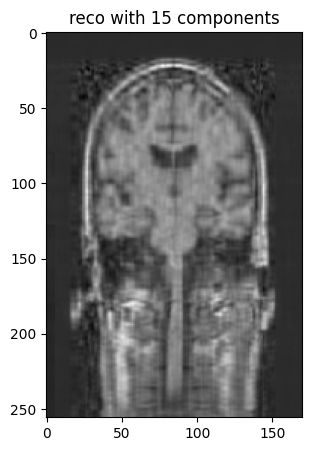

In [20]:
### BEGIN SOLUTION
@cuda.jit
def reconstruct_svd_numba(u, s, vt, C, k):
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        sum = 0
        for l in range(k):
            sum += u[i, l] * s[l] * vt[l, j]
        C[i, j] = sum

TBP = 16
@cuda.jit
def reconstruct_svd_numba_shared_memory(u, s, vt, C, k):
    """
    This kernel uses shared memory to speed up the computation.
    
    :param u: u matrix
    :param s: s vector
    :param vt: vt matrix
    :param C: result matrix
    :param k: number of components to keep
    """
    block_i = cuda.blockIdx.x
    block_j = cuda.blockIdx.y
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    i, j = cuda.grid(2)

    tmp = 0.0
    
    u_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    s_shared = cuda.shared.array(shape=(TBP), dtype=float32)

    num_blocks = math.ceil(min(k, u.shape[1]) / TBP)
    for m in range(num_blocks):
        u_shared[thread_i, thread_j] = u[block_i * TBP + thread_i, m * TBP + thread_j]
        vt_shared[thread_i, thread_j] = vt[m * TBP + thread_i, block_j * TBP + thread_j]
        if thread_j == 0:
            s_shared[thread_i] = s[m * TBP + thread_i]

        cuda.syncthreads()
        for l in range(TBP):
            if l + m * TBP < k:
                tmp += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]
        cuda.syncthreads()

    C[i, j] = tmp


u, s, vt = np.linalg.svd(image_brain, full_matrices=False)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

k = 15

threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

C = cp.asnumpy(C_gpu)
plot_reco(C, k)

### END SOLUTION

In [21]:
# mimic cupy benchmark result: https://docs.cupy.dev/en/stable/reference/generated/cupyx.profiler._time._PerfCaseResult.html#cupyx.profiler._time._PerfCaseResult
class BenchmarkResult:
    def __init__(self, gpu_times: np.ndarray, cpu_times: np.ndarray):
        self.gpu_times = gpu_times
        self.cpu_times = cpu_times


def measure_numba_kernel_reconstruction(threads_per_block, decomposed_image):
    u, s, vt = decomposed_image['u'], decomposed_image['s'], decomposed_image['vt']
    k = min(u.shape[1], vt.shape[0]) // 3 # use 1/3 of components

    
    @cuda.jit
    def reconstruct_svd_numba_shared_memory(u, s, vt, C, k):
        """
        This kernel uses shared memory to speed up the computation.
        
        :param u: u matrix
        :param s: s vector
        :param vt: vt matrix
        :param C: result matrix
        :param k: number of components to keep
        """
        block_i = cuda.blockIdx.x
        block_j = cuda.blockIdx.y
        thread_i = cuda.threadIdx.x
        thread_j = cuda.threadIdx.y
        i, j = cuda.grid(2)

        tmp = 0.0
        
        u_shared = cuda.shared.array(shape=(threads_per_block[0], threads_per_block[1]), dtype=float32)
        vt_shared = cuda.shared.array(shape=(threads_per_block[0], threads_per_block[1]), dtype=float32)
        s_shared = cuda.shared.array(shape=(threads_per_block[0]), dtype=float32)

        num_blocks = math.ceil(min(k, vt.shape[0], u.shape[1]) / threads_per_block[0])
        for m in range(num_blocks):
            u_shared[thread_i, thread_j] = u[block_i * threads_per_block[0] + thread_i, m * threads_per_block[1] + thread_j]
            vt_shared[thread_i, thread_j] = vt[m * threads_per_block[0] + thread_i, block_j * threads_per_block[1] + thread_j]
            if thread_j == 0:
                s_shared[thread_i] = s[m * threads_per_block[0] + thread_i]

            cuda.syncthreads()
            for l in range(threads_per_block[0]):
                if l + m * threads_per_block[0] < k:
                    tmp += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]
            cuda.syncthreads()

        C[i, j] = tmp

    blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    u_gpu = cp.asarray(u, dtype=np.float32)
    s_gpu = cp.asarray(s, dtype=np.float32)
    vt_gpu = cp.asarray(vt, dtype=np.float32)
    C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

    # warm up
    for i in range(10):
        reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

    cpu_times = []
    gpu_times = []

    for i in range(10):
        gpu_start_event = cuda.event()
        gpu_end_event = cuda.event()

        gpu_start_event.record()
        cpu_start = time.perf_counter()   

        reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

        cpu_end = time.perf_counter()
        gpu_end_event.record()
        cuda.synchronize()

        cpu_times.append(cpu_end - cpu_start)
        gpu_times.append(cuda.event_elapsed_time(gpu_start_event, gpu_end_event) / 1000)
    return {
                "result": BenchmarkResult(np.array(gpu_times), np.array(cpu_times)),
                "image_size": (u.shape[0], vt.shape[1]),
                "k": k,
                "blocks_per_grid": blocks_per_grid,
                "threads_per_block": threads_per_block,
            }

block_configurations_shared_memory = []
block_configurations_shared_memory.extend(block_configurations)
for i in range(2, 5):
    block_configurations_shared_memory.append((2**(i+1), 2**(i-1)))
    if i < 4:
        block_configurations_shared_memory.append((2**(i+2), 2**(i-1)))
        block_configurations_shared_memory.append((2**(i+2), 2**(i-2)))
    if i < 3:
        block_configurations_shared_memory.append((2**(i+3), 2**(i-2)))

experiment_results_shared_memory = []
for image in decompositions.keys():
    print(f"Image {image}")
    for threads_per_block in tqdm(block_configurations_shared_memory):
        #print(f"Threads per block {threads_per_block}")
        experiment_results_shared_memory.append(measure_numba_kernel_reconstruction(threads_per_block, decompositions[image]))

Image test_image_1


100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


Image test_image_2


100%|██████████| 32/32 [00:50<00:00,  1.57s/it]


Image test_image_3


100%|██████████| 32/32 [06:04<00:00, 11.38s/it]


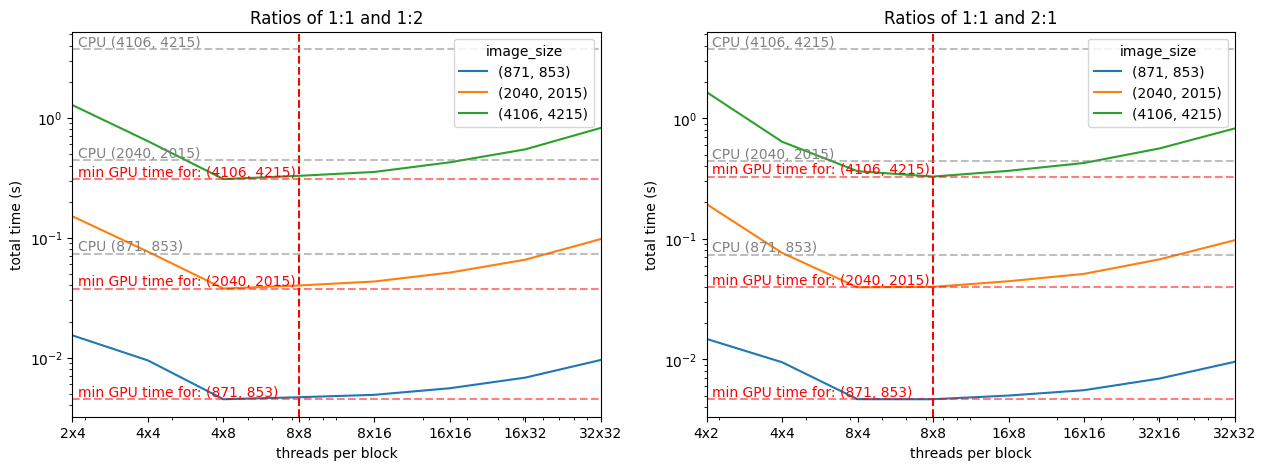

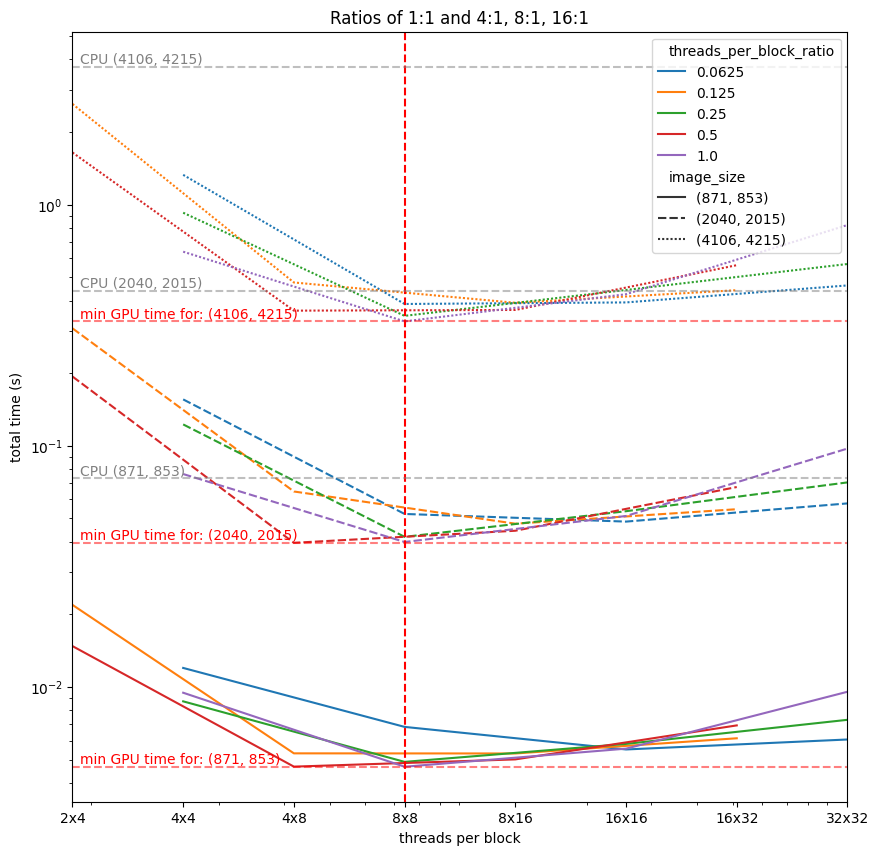

In [29]:
df_shared_memory = convert_experiment_results_to_df(experiment_results_shared_memory)
plot_ratios(df_shared_memory)

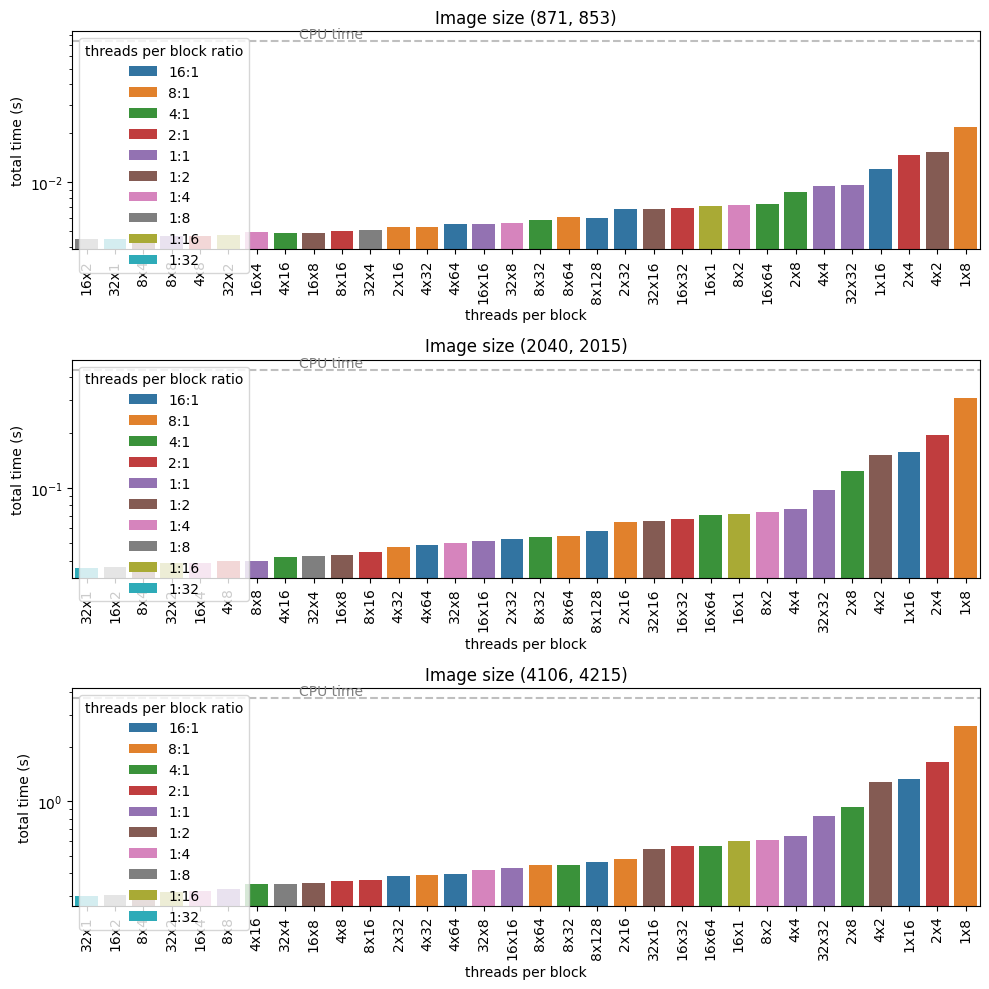

In [38]:
plot_time_over_ratios(df_shared_memory)

In [31]:
# print max speedup for each image size
df_shared_memory.groupby(['image_size'])['speedup'].max()

image_size
(871, 853)      16.547834
(2040, 2015)    12.033306
(4106, 4215)    12.511038
Name: speedup, dtype: float64

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

In den obenstehenden Grafiken ist wieder die Performance der Rekonstruktion mit Blockgrössen im Verhältnis von 1:1 und 1:2 und 1:1 und 2:1 zu sehen. Interessant ist, dass jetzt die Konfigurationen 32x1 und 16x2 die besseren Resultate erziehlt. 

Durch das Verwenden von Shared Memory kann die GPU mehrmals verwendete Elemente schneller laden und muss sie nur noch einmal von der GPU laden. Die GPU berechnet sozusagen Submatrix-Multiplikationen (oder bessergesagt Rekonstruktionen) indem sie kleinere Matrizen von $u$ und $vT$ und $s$ ins Shared Memory lädt und dann die Rekonstruktion durchführt.

Trotzdem ist die Performance jetzt ein wenig schlechter mit einem maximalen Speedup von ~12x.

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

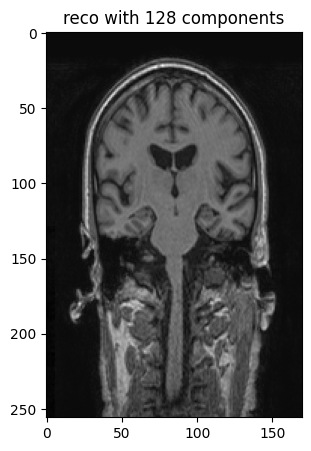

In [121]:
TBP = 16
@cuda.jit
def reconstruct_svd_numba_shared_memory_prefetch(u, s, vt, C, k):
    """
    This kernel uses shared memory to speed up the computation.
    
    :param u: u matrix
    :param s: s vector
    :param vt: vt matrix
    :param C: result matrix
    :param k: number of components to keep
    """
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    i, j = cuda.grid(2)

    tmp = 0.0
    
    u_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    s_shared = cuda.shared.array(shape=(TBP), dtype=float32)

    
    u_shared_next = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    vt_shared_next = cuda.shared.array(shape=(TBP, TBP), dtype=float32)
    s_shared_next = cuda.shared.array(shape=(TBP), dtype=float32)

    num_blocks = math.ceil(min(k, u.shape[1]) / TBP)
    
    for m in range(num_blocks):
        # Load next block into "_next" shared memory while processing current block
        if m < num_blocks - 1:
            u_shared_next[thread_i, thread_j] = u[i, j] if i < u.shape[0] and (j + TBP) < u.shape[1] else 0.0
            vt_shared_next[thread_i, thread_j] = vt[i, j] if i < vt.shape[0] and (j + TBP) < vt.shape[1] else 0.0
            if thread_j == 0:
                s_shared_next[thread_i] = s[i] if i < s.shape[0] and (i + TBP) < s.shape[0] else 0.0
        
        cuda.syncthreads()

        for l in range(TBP):
            if l + m * TBP < k:
                tmp += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]

        # Synchronize again before swapping the shared memory blocks
        cuda.syncthreads()
        
        # Swap the shared memory blocks for the next iteration
        u_shared, u_shared_next = u_shared_next, u_shared
        vt_shared, vt_shared_next = vt_shared_next, vt_shared
        s_shared, s_shared_next = s_shared_next, s_shared
        
        # Synchronize again to make sure all threads have swapped their shared memory blocks
        cuda.syncthreads()

    if i < C.shape[0] and j < C.shape[1]:
        C[i, j] = tmp

u, s, vt = np.linalg.svd(image_brain, full_matrices=False)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

k = 128

threads_per_block = (TBP, TBP)
blocks_per_grid_x = math.ceil(u.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

C = cp.asnumpy(C_gpu)
plot_reco(C, k)



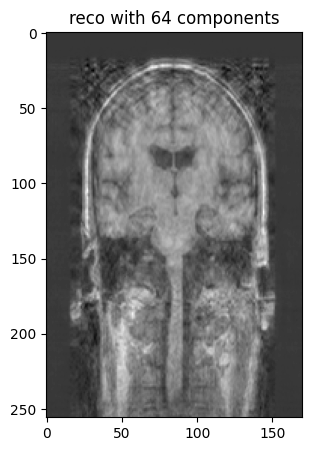

In [118]:
### BEGIN SOLUTION
TBP = 8
TBP2 = 16
@cuda.jit
def reconstruct_svd_numba_shared_memory_multiple_tiles(u, s, vt, C, k):
    block_i = cuda.blockIdx.x
    block_j = cuda.blockIdx.y
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y

    i1 = block_i * TBP * 2 + thread_i
    j1 = block_j * TBP * 2 + thread_j
    i2, j2 = i1 + TBP, j1 + TBP

    tmp_11, tmp_12, tmp_21, tmp_22 = 0.0, 0.0, 0.0, 0.0

    # Define shared memory for current and next tiles
    u_shared = cuda.shared.array(shape=(TBP2, TBP), dtype=float32)
    vt_shared = cuda.shared.array(shape=(TBP, TBP2), dtype=float32)
    s_shared = cuda.shared.array(shape=(TBP), dtype=float32)
    
    u_shared_next = cuda.shared.array(shape=(TBP2, TBP), dtype=float32)
    vt_shared_next = cuda.shared.array(shape=(TBP, TBP2), dtype=float32)
    s_shared_next = cuda.shared.array(shape=(TBP), dtype=float32)

    # Load the first blocks into shared memory
    u_shared [thread_i      , thread_j] = u [i1      , thread_j]
    u_shared [thread_i + TBP, thread_j] = u [i2      , thread_j]
    vt_shared[thread_i, thread_j      ] = vt[thread_i, j1      ]
    vt_shared[thread_i, thread_j + TBP] = vt[thread_i, j2      ]
    if thread_j == 0:
        s_shared [thread_i] = s[thread_i]
    
    cuda.syncthreads()

    # Compute number of tiles
    num_blocks = math.ceil(min(k, u.shape[1]) / TBP)

    for m in range(num_blocks):
        # Load next block into "_next" shared memory while processing current block
        if m < num_blocks - 1:
            offset = (m+1) * TBP
            u_shared_next [thread_i      , thread_j] = u [i1               , offset + thread_j]
            u_shared_next [thread_i + TBP, thread_j] = u [i2               , offset + thread_j]
            vt_shared_next[thread_i, thread_j      ] = vt[offset + thread_i, j1               ]
            vt_shared_next[thread_i, thread_j + TBP] = vt[offset + thread_i, j2               ]
            if thread_j == 0:
                s_shared_next[thread_i] = s[offset + thread_i]

        for l in range(TBP):
            if l + m * TBP < k:
                # Calculate each sub-matrix
                tmp_11 += u_shared[thread_i      , l] * s_shared[l] * vt_shared[l, thread_j      ]
                tmp_12 += u_shared[thread_i      , l] * s_shared[l] * vt_shared[l, thread_j + TBP]
                tmp_21 += u_shared[thread_i + TBP, l] * s_shared[l] * vt_shared[l, thread_j      ]
                tmp_22 += u_shared[thread_i + TBP, l] * s_shared[l] * vt_shared[l, thread_j + TBP]
        # Synchronize again before swapping the shared memory blocks
        cuda.syncthreads()
        
        # Swap the shared memory blocks for the next iteration
        u_shared, u_shared_next = u_shared_next, u_shared
        vt_shared, vt_shared_next = vt_shared_next, vt_shared
        s_shared, s_shared_next = s_shared_next, s_shared

        # Synchronize again to make sure all threads have swapped their shared memory blocks
        cuda.syncthreads()

    # Write results
    if i1 < C.shape[0] and j1 < C.shape[1]:
        C[i1, j1] = tmp_11
    if i1 < C.shape[0] and j2 < C.shape[1]:
        C[i1, j2] = tmp_12
    if i2 < C.shape[0] and j1 < C.shape[1]:
        C[i2, j1] = tmp_21
    if i2 < C.shape[0] and j2 < C.shape[1]:
        C[i2, j2] = tmp_22

        
u, s, vt = np.linalg.svd(image_brain, full_matrices=False)

u_gpu = cp.asarray(u, dtype=np.float32)
s_gpu = cp.asarray(s, dtype=np.float32)
vt_gpu = cp.asarray(vt, dtype=np.float32)
C_gpu = cp.zeros((u.shape[0], vt.shape[1]), dtype=np.float32)

k = 64

threads_per_block = (TBP, TBP)
blocks_per_grid_x = math.ceil(u.shape[0] / (2 * threads_per_block[0]))  # Divide by 2
blocks_per_grid_y = math.ceil(vt.shape[1] / (2 * threads_per_block[1]))  # Divide by 2
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

reconstruct_svd_numba_shared_memory_multiple_tiles[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

C = cp.asnumpy(C_gpu)
plot_reco(C, k)

### END SOLUTION

Da meine Implementation mit mehreren Tiles nicht funktioniert, habe ich nur die Prefetch variante vergliche:

Warmup shared memory kernel


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Measure shared memory kernel


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Warmup prefetch kernel


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Measure prefetch kernel


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


<Axes: xlabel='name', ylabel='time'>

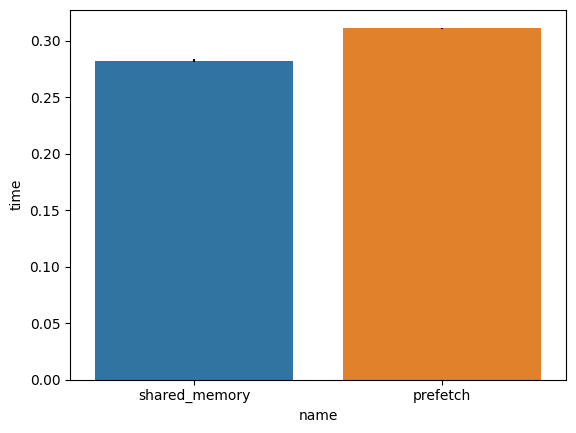

In [122]:
# calculate speedup compared to the shared memory kernel
test_image_3 = decompositions['test_image_3']
k = 1000
u_gpu = cp.asarray(test_image_3['u'][:, :k], dtype=np.float32)
s_gpu = cp.asarray(test_image_3['s'][:k], dtype=np.float32)
vt_gpu = cp.asarray(test_image_3['vt'][:k, :], dtype=np.float32)
C_gpu = cp.zeros((u_gpu.shape[0], vt_gpu.shape[1]), dtype=np.float32)

threads_per_block = (TBP, TBP)
blocks_per_grid_x = math.ceil(u_gpu.shape[0] / threads_per_block[0])
blocks_per_grid_y = math.ceil(vt_gpu.shape[1] / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)


print("Warmup shared memory kernel")
for i in tqdm(range(10)):
    reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

print("Measure shared memory kernel")
shared_memory_times = []
for i in tqdm(range(10)):
    shared_memory_times.append(timeit.timeit(lambda: reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k), number=1))

prefetch_times = []
print("Warmup prefetch kernel")
for i in tqdm(range(10)):
    reconstruct_svd_numba_shared_memory_prefetch[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

print("Measure prefetch kernel")
for i in tqdm(range(10)):
    prefetch_times.append(timeit.timeit(lambda: reconstruct_svd_numba_shared_memory_prefetch[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k), number=1))

shared_memory_times = np.array(shared_memory_times)
measures = pd.DataFrame({
    "name": ["shared_memory", "prefetch"],
    "time": [shared_memory_times.mean(), np.array(prefetch_times).mean()],
    "std": [shared_memory_times.std(), np.array(prefetch_times).std()]
})
sns.barplot(x="name", y="time", data=measures, yerr=measures['std'])

Interessanterweise ist die Prefetch Variante nicht schneller als die Shared Memory Variante. Ich weiss nicht ob numba hier die Prefetch Instruktionen richtig umsetzt.

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

In [ ]:
# first dump the images as a pickle file
with open('decomposition_test_image_3.pickle', 'wb') as f:
    pickle.dump(decompositions['test_image_3'], f)
with open('decomposition_test_image_2.pickle', 'wb') as f:
    pickle.dump(decompositions['test_image_2'], f)
with open('decomposition_test_image_1.pickle', 'wb') as f:
    pickle.dump(decompositions['test_image_1'], f)

In [42]:
# ich finde es interessant, dass bei der Blockkonfiguration auch das Seitenverhältnis eine Rolle spielt
# deshalb analysiere ich die beste Blockkonfiguration und das umgekehrte Seitenverhältnis auf dem grössten Bild

# Test 1: 32x1
!nvprof --kernels .*__main__.* --analysis-metrics -o 32x1-%p.nvvp --profile-child-processes python .\nvprof_reconstruction.py 32 1

# Test 2: 1x32
!nvprof --kernels .*__main__.* --analysis-metrics -o 1x32-%p.nvvp --profile-child-processes python .\nvprof_reconstruction.py 1 32

======== Warning: GPU PC sampling feature is not available under multi-process profiling mode
and will be ignored.
==6084== NVPROF is profiling process 6084, command: C:\Program Files\Python310\python.exe .\nvprof_reconstruction.py 32 1
==6084== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.
==6084== Generated result file: d:\dev\hpc-m2\8x4-6084.nvvp


Image size: 4225x4004
SVD shapes: (4225, 4004), (4004,), (4004, 4004)
Blocks per grid: (133, 4004)
Done in 2708.4550504 seconds!
Image size: 4225x4004
SVD shapes: (4225, 4004), (4004,), (4004, 4004)
Blocks per grid: (133, 4004)
Done in 3267.676196100001 seconds!


======== Warning: GPU PC sampling feature is not available under multi-process profiling mode
and will be ignored.
==8960== NVPROF is profiling process 8960, command: C:\Program Files\Python310\python.exe .\nvprof_reconstruction.py 32 1
==8960== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.
==8960== Generated result file: d:\dev\hpc-m2\32x1-8960.nvvp
======== Warning: GPU PC sampling feature is not available under multi-process profiling mode
and will be ignored.
==10344== NVPROF is profiling process 10344, command: C:\Program Files\Python310\python.exe .\nvprof_reconstruction.py 1 32
==10344== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.
==10344== Generated result file: d:\dev\hpc-m2\4x8-10344.nvvp


Image size: 4225x4004
SVD shapes: (4225, 4004), (4004,), (4004, 4004)
Blocks per grid: (4225, 126)
Done in 6380.043662100001 seconds!
Image size: 4225x4004
SVD shapes: (4225, 4004), (4004,), (4004, 4004)
Blocks per grid: (4225, 126)
Done in 3107.930886899998 seconds!


======== Warning: GPU PC sampling feature is not available under multi-process profiling mode
and will be ignored.
==11824== NVPROF is profiling process 11824, command: C:\Program Files\Python310\python.exe .\nvprof_reconstruction.py 1 32
==11824== Some kernel(s) will be replayed on device 0 in order to collect all events/metrics.
==11824== Generated result file: d:\dev\hpc-m2\1x32-11824.nvvp


In [2]:
!nvvp -vm "C:\Program Files\Java\jre-1.8\bin\java"

##### Ressource utilization
32x1:

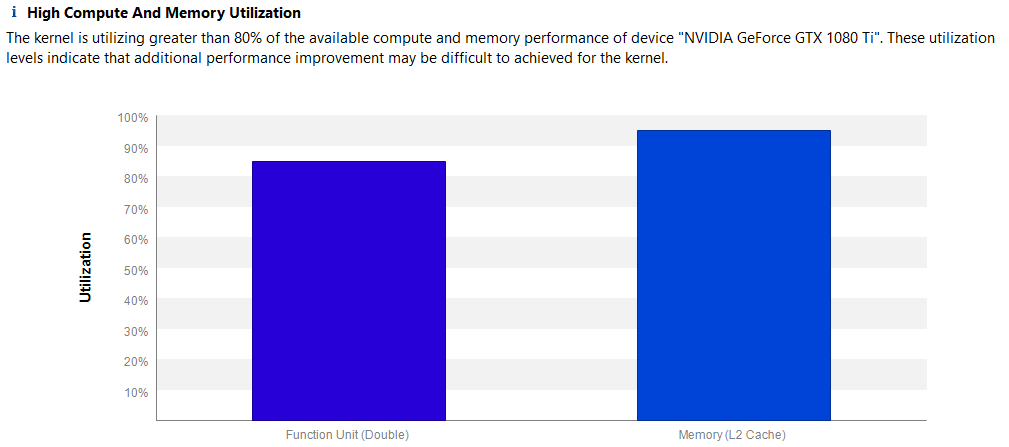

1x32:

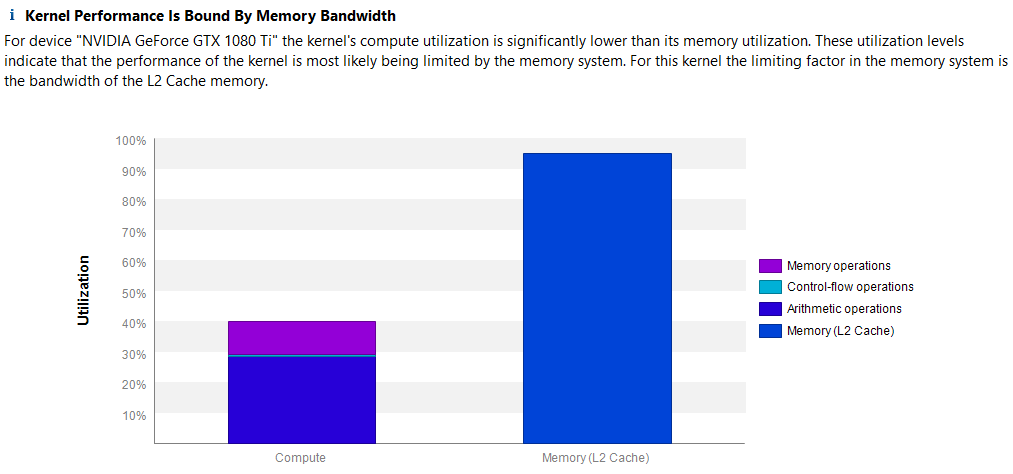

Aus den obenstehenden Grafiken ist ersichtlich, dass bei einer 32x1 Blockkonfiguration die Function Unit zu 85% ausgelastet ist, während bei einer 1x32 Blockkonfiguration die Function Unit nur zu 30% ausgelastet ist. Das Shared Memory bleibt bei beiden Konfigurationen gleich ausgelastet (95%). Hier kann man klar sehen, dass die 32x1 Konfiguration schneller ist als die 1x32 Konfiguration, da Sie zwar gleich viel Daten in das Shared Memory lädt, aber die Function Unit besser auslasten kann. Der Profiler gibt direkt an, dass man die 1x32 Konfiguration noch verbessern kann.

##### NCU Profiling

32x1:

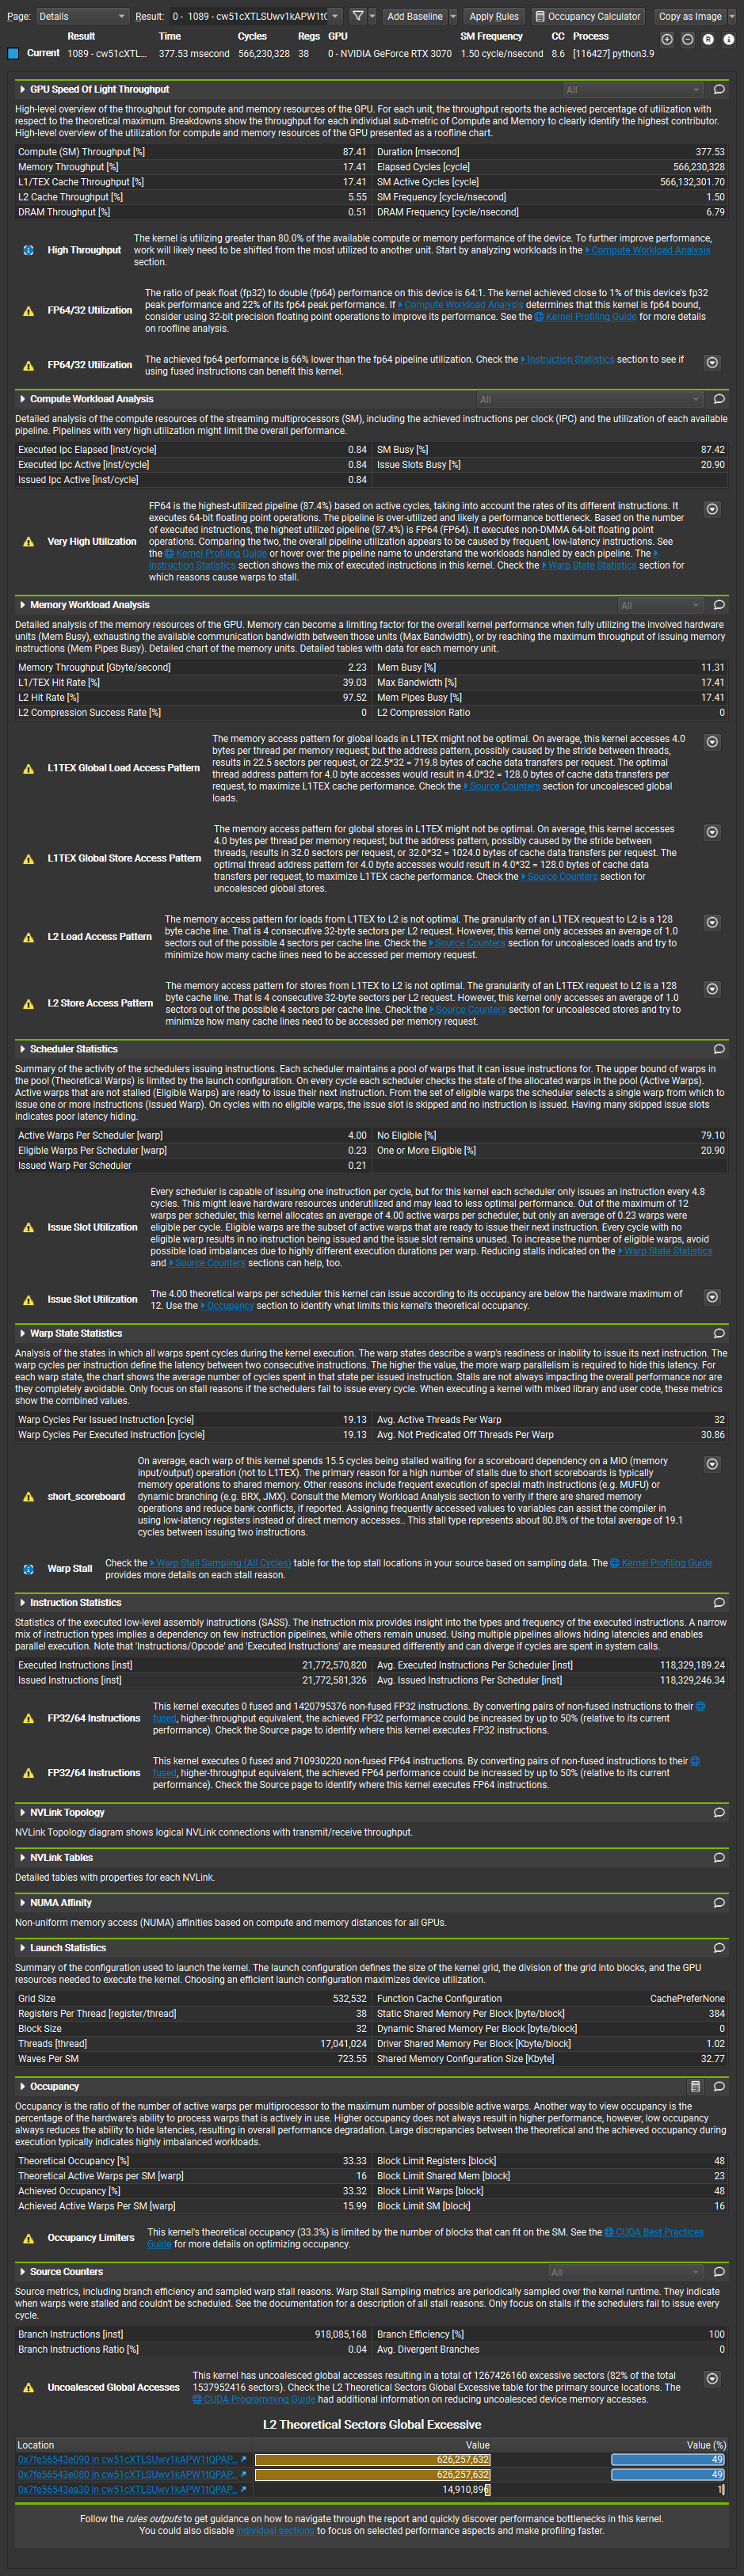

Da ich meine GPU nicht genug modern ist um mit ncu ein Profiling durchzuführen, habe ich nur das Profiling der 32x1 Konfiguration (von Simon).

Aus dieser Grafik entnehme ich folgende zwei Haupterkenntnisse:
 - Meine Speicherzugriffe scheinen nicht optimal zu sein, dass sieht man an diversen Warnungen über die Access Patterns auf L1TEX und L2. Auch benutze ich Uncoalesced Zugriffe, leider sehe ich nicht genau wo dies in meinem Code passiert, da ich nur C/C++ Code anhängen kann und nicht den Python Code.
 - Wenn meine Kernel-Funktion stalled, dann ist dies weil sie auf einen Memory Input/Outpu MIO wartet. Der meiste Grund dafür sind Shared Memory Accesses und damit entstehende Bank Conflicts. Tatsächlich habe ich über 1. Mio Bankconflicts aber auf ein Total von 2.2 Mrd. Zugriffen scheint mir dies nicht so viel. Ich vermute, dass die Bank Conflicts nicht das Problem sind, sondern die Uncoalesced Zugriffe.

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [5]:
### BEGIN SOLUTION
# I originally had this in another file so I could run profiling on it

def get_queue(method):
    adni_decopositions = queue.Queue()
    if method == "adni":
        for subdir, dirs, files in os.walk('adni_png'):
            print(f"Loading images from {subdir}")
            for file in tqdm(files):
                if file.endswith('.png'):
                    with open(os.path.join(subdir, file), 'rb') as f:
                        image = imageio.imread(f)
                    # normalize image
                        image = image - image.min() / (image.max() - image.min())
                    # copy image to gpu
                        image_gpu = cp.asarray(image, dtype=np.float32)
                    # decompose image
                        u, s, vt = cp.linalg.svd(image_gpu)
                    # store decomposition
                        u = cp.asnumpy(u)
                        s = cp.asnumpy(s)
                        vt = cp.asnumpy(vt)
                        u_pinned = cuda.pinned_array_like(u)
                        np.copyto(u_pinned, u)
                        s_pinned = cuda.pinned_array_like(s)
                        np.copyto(s_pinned, s)
                        vt_pinned = cuda.pinned_array_like(vt)
                        np.copyto(vt_pinned, vt)

                        adni_decopositions.put({
                        "image": image,
                        "u": u_pinned,
                        "s": s_pinned,
                        "vt": vt_pinned
                    })

        print(f"Loaded {adni_decopositions.qsize()} images")
    elif method == "test":
    # load decompositions from decomposition_test_image_3.pickle
        with open("decomposition_test_image_3.pickle", "rb") as f:
            decomposition = pickle.load(f)

        decomposition_pinned = {}
    # copy to pinned host memory
        decomposition_pinned["u"] = cuda.pinned_array_like(decomposition["u"])
        np.copyto(decomposition_pinned["u"], decomposition["u"])
        decomposition_pinned["s"] = cuda.pinned_array_like(decomposition["s"])
        np.copyto(decomposition_pinned["s"], decomposition["s"])
        decomposition_pinned["vt"] = cuda.pinned_array_like(decomposition["vt"])
        np.copyto(decomposition_pinned["vt"], decomposition["vt"])

    # add the test_image_3 decomposition to the queue 100 times
        for i in range(100):
            adni_decopositions.put(decomposition_pinned)
    else:
        print("Please specify adni or test as first argument")
    return adni_decopositions

threads_per_block = (32, 1)

@cuda.jit
def reconstruct_svd_numba_shared_memory(u, s, vt, C, k):
    """
    This kernel uses shared memory to speed up the computation.
    
    :param u: u matrix
    :param s: s vector
    :param vt: vt matrix
    :param C: result matrix
    :param k: number of components to keep
    """
    block_i = cuda.blockIdx.x
    block_j = cuda.blockIdx.y
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    i, j = cuda.grid(2)

    tmp = 0.0
    
    u_shared = cuda.shared.array(shape=(threads_per_block[0], threads_per_block[1]), dtype=float32)
    vt_shared = cuda.shared.array(shape=(threads_per_block[0], threads_per_block[1]), dtype=float32)
    s_shared = cuda.shared.array(shape=(threads_per_block[0]), dtype=float32)

    num_blocks = math.ceil(min(k, vt.shape[0], u.shape[1]) / threads_per_block[0])
    for m in range(num_blocks):
        u_shared[thread_i, thread_j] = u[block_i * threads_per_block[0] + thread_i, m * threads_per_block[1] + thread_j]
        vt_shared[thread_i, thread_j] = vt[m * threads_per_block[0] + thread_i, block_j * threads_per_block[1] + thread_j]
        if thread_j == 0:
            s_shared[thread_i] = s[m * threads_per_block[0] + thread_i]

        cuda.syncthreads()
        for l in range(threads_per_block[0]):
            if l + m * threads_per_block[0] < k:
                tmp += u_shared[thread_i, l] * s_shared[l] * vt_shared[l, thread_j]
        cuda.syncthreads()

    C[i, j] = tmp

### END SOLUTION

In [6]:
# use numba for streams and events

adni_decopositions = get_queue("test")
NUM_STREAMS = 4
streams = [cuda.stream() for _ in range(NUM_STREAMS)]
events = [cuda.event() for _ in range(len(streams))]


def reconstruct_one_decomposition(adni_decopositions, threads_per_block, stream):
    decomp = adni_decopositions.get()
# TODO: assign two buffers for each stream
# then use these buffers to copy to device
# - profile
# - send to simon marcin to profile
    u_gpu = cuda.to_device(decomp['u'], stream=stream, to = )
    s_gpu = cuda.to_device(decomp['s'], stream=stream)
    vt_gpu = cuda.to_device(decomp['vt'], stream=stream)
    C_gpu = cuda.device_array((u_gpu.shape[0], vt_gpu.shape[1]), dtype=np.float32, stream=stream)
    k = min(u_gpu.shape[1], vt_gpu.shape[0])

    blocks_per_grid_x = math.ceil(C_gpu.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(C_gpu.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block, stream](u_gpu, s_gpu, vt_gpu, C_gpu, k)
    """
    C = cuda.pinned_array_like(C_gpu)
    C_gpu.copy_to_host(stream=stream)
    """


start = time.perf_counter()
# initialize streams
for i, (event, stream) in enumerate(zip(events, streams)):
    reconstruct_one_decomposition(adni_decopositions, threads_per_block, stream)
    event.record(stream=stream)
    reconstruct_one_decomposition(adni_decopositions, threads_per_block, stream)
print("Initialized all streams")


while not adni_decopositions.empty():
    for i, (event, stream) in enumerate(zip(events, streams)):
        # query events[i] if it has been recorded
        if event.query() and not adni_decopositions.empty():
            event.record(stream=stream)
            reconstruct_one_decomposition(adni_decopositions, threads_per_block, stream)
    print(f"Decompositions left: {adni_decopositions.qsize()}")
print("All decompositions have been reconstructed")

# wait for all streams to finish
for stream in streams:
    stream.synchronize()
end = time.perf_counter()
print(f"Total time: {end - start}")

Initialized all streams
Decompositions left: 88
Decompositions left: 84
Decompositions left: 80
Decompositions left: 76
Decompositions left: 72
Decompositions left: 68
Decompositions left: 64
Decompositions left: 60
Decompositions left: 56
Decompositions left: 52
Decompositions left: 48
Decompositions left: 44
Decompositions left: 40
Decompositions left: 36
Decompositions left: 32
Decompositions left: 28
Decompositions left: 24
Decompositions left: 20
Decompositions left: 16
Decompositions left: 12
Decompositions left: 8
Decompositions left: 4
Decompositions left: 0
All decompositions have been reconstructed
Total time: 80.93295810000018


In [7]:
def reconstruct_one_decomposition_serial(adni_decopositions, threads_per_block):
    decomp = adni_decopositions.get()

    u_gpu = cuda.to_device(decomp['u'])
    s_gpu = cuda.to_device(decomp['s'])
    vt_gpu = cuda.to_device(decomp['vt'])
    C_gpu = cuda.device_array((u_gpu.shape[0], vt_gpu.shape[1]), dtype=np.float32)
    k = min(u_gpu.shape[1], vt_gpu.shape[0])

    blocks_per_grid_x = math.ceil(C_gpu.shape[0] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(C_gpu.shape[1] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    reconstruct_svd_numba_shared_memory[blocks_per_grid, threads_per_block](u_gpu, s_gpu, vt_gpu, C_gpu, k)

start = time.perf_counter()
adni_decopositions = get_queue("test")
while not adni_decopositions.empty():
    reconstruct_one_decomposition_serial(adni_decopositions, threads_per_block)
    print(f"Decompositions left: {adni_decopositions.qsize()}")
end = time.perf_counter()
print(f"Serial reconstruction took {end - start} seconds")

Decompositions left: 99
Decompositions left: 98
Decompositions left: 97
Decompositions left: 96
Decompositions left: 95
Decompositions left: 94
Decompositions left: 93
Decompositions left: 92
Decompositions left: 91
Decompositions left: 90
Decompositions left: 89
Decompositions left: 88
Decompositions left: 87
Decompositions left: 86
Decompositions left: 85
Decompositions left: 84
Decompositions left: 83
Decompositions left: 82
Decompositions left: 81
Decompositions left: 80
Decompositions left: 79
Decompositions left: 78
Decompositions left: 77
Decompositions left: 76
Decompositions left: 75
Decompositions left: 74
Decompositions left: 73
Decompositions left: 72
Decompositions left: 71
Decompositions left: 70
Decompositions left: 69
Decompositions left: 68
Decompositions left: 67
Decompositions left: 66
Decompositions left: 65
Decompositions left: 64
Decompositions left: 63
Decompositions left: 62
Decompositions left: 61
Decompositions left: 60
Decompositions left: 59
Decompositions l

Die parallele Rekonstruktion braucht 80.9 Sekunden und ist damit eine halbe Sekunde schneller als die sequentielle Rekonstruktion mit 81.4 Sekunden.

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

Der Speedup ist minimal (1/160). Dies ist auf folgende Tatsache zurückzuführen:
- Die Kernel-Funktion dauert im Vergleich zu den beiden Copy-Engines viel länger. Der Speedup ist minimal, weil nur eine Kernel-Funktion parallel ausgeführt werden kann und die  Copy-Engines zwar schon parallel ausgeführt werden, aber viel weniger Zeit brauchen als die Kernel-Funktion.

In einem Profiling habe ich festgestellt, dass wenn ich das Bild wieder zurück auf den Host kopiere, die Engines plötzlich wieder sequentiell laufen. Ich habe nicht herausgefunden wieso dies der Fall ist. Aber wenn ich die D2H-Engine weglasse, läuft das ganze parallel.

Zusammenhang zwischen Amadahl und Gustafson:
- Amadahl: Der Speedup ist beschränkt durch die sequentielle Ausführung von Teilen des Programms. In meinem Fall sind das die Copy-Engines. Wenn man mehr SMs hinzufügt, nimmt die Geschwindigkeit zwar zu, stagniert aber bei einem gewissen Punkt, da die Copy-Engines nicht schneller werden.
- Gustafson: betrachtet das Problem so: ein grösseres Problem in gleicher Zeit zu lösen indem man mehr Rechenleistung hinzufügt. Gustafson geht davon aus, dass dabei der serielle Teil konstant bleibt. Hier ist das nicht der Fall, da die Bandbreite der Copy-Engines konstant und somit den seriellen Teil ausmacht.

Da die Copy-Vorgänge parallel zur Kernel-Funktion gehen und viel weniger Zeit brauchen als die Kernel-Funktion. Ist der Speedup proportional zur Rechenleistung, bis das Kopieren gleich lange dauert wie die Kernel-Funktion. Danach ist kein Speedup mehr möglich.

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


![component diagram.drawio.svg](./images/component%20diagram.drawio.png)

In diesm Diagramm sind alle beteiligten Komponenten sichtbar inklusive, wie diese gruppiert werden. Die SSD beinhaltet nur die Bilder, die CPU beinhaltet die Prozessoren und den RAM, die GPU beinhaltet die Streaming Prozessoren mit ihrem Shared Memory sowie das Device Memory und die beiden Copy-Engines Host-to-Device und Device-to-Host.
 
 [![](https://mermaid.ink/img/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gICAgcGFydGljaXBhbnQgU1NEIGFzIFNTRFxuICAgIHBhcnRpY2lwYW50IENQVSBhcyBDUFVcbiAgICBwYXJ0aWNpcGFudCBHUFUgYXMgR1BVXG4gICAgXG4gICAgU1NELT4-Q1BVOiBMb2FkIEltYWdlc1xuICAgIGxvb3AgRXZlcnkgaW1hZ2VcblxuICAgICAgICBDUFUtPj5HUFU6IExvYWQgSW1hZ2VzXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBVc2luZyBIMkQgZW5naW5lXG4gICAgICAgIEdQVS0-PkdQVTogRGVjb21wb3NlIEltYWdlcyB1c2luZyBTVkRcbiAgICAgICAgR1BVLT4-Q1BVOiBTdG9yZSBtYXRyaWNlcyAoVSwgU2lnbWEsIFYpXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBVc2luZyBEMkggZW5naW5lXG4gICAgZW5kXG4gICAgbG9vcCBFdmVyeSBpbWFnZVxuICAgICAgICBDUFUtPj5HUFU6IFRyYW5zZmVyIG1hdHJpY2VzXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgSDJEIGNvbW1hbmQgdG8gU3RyZWFtXG4gICAgICAgIEdQVS0-PkdQVTogUmVjb25zdHJ1Y3QgaW1hZ2VcbiAgICAgICAgbm90ZSBvdmVyIEdQVTogQWRkIGtlcm5lbCBjb21tYW5kIHRvIFN0cmVhbVxuICAgICAgICBHUFUtPj5DUFU6IFRyYW5zZmVyIGltYWdlXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgRDJIIGNvbW1hbmQgdG8gU3RyZWFtXG4gICAgICAgIENQVS0-PkdQVTogUmVjb3JkIGV2ZW50XG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgZXZlbnQgdG8gU3RyZWFtXG4gICAgICAgIEdQVS0-PkNQVTogTm90aWZ5IEV2ZW50XG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgRDJIIGNvbW1hbmQgdG8gU3RyZWFtXG4gICAgICAgIG5vdGUgb3ZlciBDUFU6IFdhaXQgZm9yIGV2ZW50IGFuZCBhZGQgbmV4dCBpbWFnZVxuICAgIGVuZCIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)](https://mermaid-js.github.io/docs/mermaid-live-editor-beta/#/edit/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gICAgcGFydGljaXBhbnQgU1NEIGFzIFNTRFxuICAgIHBhcnRpY2lwYW50IENQVSBhcyBDUFVcbiAgICBwYXJ0aWNpcGFudCBHUFUgYXMgR1BVXG4gICAgXG4gICAgU1NELT4-Q1BVOiBMb2FkIEltYWdlc1xuICAgIGxvb3AgRXZlcnkgaW1hZ2VcblxuICAgICAgICBDUFUtPj5HUFU6IExvYWQgSW1hZ2VzXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBVc2luZyBIMkQgZW5naW5lXG4gICAgICAgIEdQVS0-PkdQVTogRGVjb21wb3NlIEltYWdlcyB1c2luZyBTVkRcbiAgICAgICAgR1BVLT4-Q1BVOiBTdG9yZSBtYXRyaWNlcyAoVSwgU2lnbWEsIFYpXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBVc2luZyBEMkggZW5naW5lXG4gICAgZW5kXG4gICAgbG9vcCBFdmVyeSBpbWFnZVxuICAgICAgICBDUFUtPj5HUFU6IFRyYW5zZmVyIG1hdHJpY2VzXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgSDJEIGNvbW1hbmQgdG8gU3RyZWFtXG4gICAgICAgIEdQVS0-PkdQVTogUmVjb25zdHJ1Y3QgaW1hZ2VcbiAgICAgICAgbm90ZSBvdmVyIEdQVTogQWRkIGtlcm5lbCBjb21tYW5kIHRvIFN0cmVhbVxuICAgICAgICBHUFUtPj5DUFU6IFRyYW5zZmVyIGltYWdlXG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgRDJIIGNvbW1hbmQgdG8gU3RyZWFtXG4gICAgICAgIENQVS0-PkdQVTogUmVjb3JkIGV2ZW50XG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgZXZlbnQgdG8gU3RyZWFtXG4gICAgICAgIEdQVS0-PkNQVTogTm90aWZ5IEV2ZW50XG4gICAgICAgIG5vdGUgb3ZlciBDUFUsR1BVOiBBZGQgRDJIIGNvbW1hbmQgdG8gU3RyZWFtXG4gICAgICAgIG5vdGUgb3ZlciBDUFU6IFdhaXQgZm9yIGV2ZW50IGFuZCBhZGQgbmV4dCBpbWFnZVxuICAgIGVuZCIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)

 Dieses Sequenzdigram stellt den Ablauf mehr aus Sicht der CPU dar und wie diese mit der SSD und der GPU interagiert. Die CPU lädt zuerst alle Bilder und zerlegt sie in einem Loop auf der GPU. Im eigentlichen Rekonstruktionsprozess sendet die GPU für jeden Stream ein Bild an die GPu, diese rekonstruiert das Bild und sendet es zurück an die CPU. Dann fügt die CPU ein Event ein um zu wissen, wann dieser Stream fertig ist. Sobald der Stream fertig ist, wird das nächste Bild an die GPU gesendet.


 [![](https://mermaid.ink/img/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gICAgcGFydGljaXBhbnQgUkFNIGFzIFJBTVxuICAgIHBhcnRpY2lwYW50IERNZW0gYXMgRGV2aWNlIE1lbW9yeVxuICAgIHBhcnRpY2lwYW50IFNNZW0gYXMgU2hhcmVkIE1lbW9yeVxuXG4gICAgbG9vcCBFdmVyeSBpbWFnZVxuICAgICAgICBSQU0tPj5SQU06IHBpbiBtYXRyaWNlc1xuICAgICAgICBSQU0tPj5ETWVtOiBMb2FkIG1hdHJpY2VzIChVLCBTaWdtYSwgVikgdG8gRGV2aWNlIE1lbW9yeVxuICAgICAgICBub3RlIG92ZXIgUkFNLERNZW06IFVzaW5nIEgyRCBlbmdpbmVcbiAgICAgICAgbG9vcCBrZXJuZWw6IGZvciBldmVyeSB0aWxlXG4gICAgICAgICAgICBETWVtLT4-U01lbTogTG9hZCBzdWJtYXRyaWNlcyBmb3IgKFUsIFMsIFYpXG4gICAgICAgICAgICBOb3RlIG92ZXIgU01lbTogQWN0dWFsIHJlY29uc3RydWN0aW9uIG9uIFNNXG4gICAgICAgICAgICBTTWVtLT4-RE1lbTogU3RvcmUgcmVjb25zdHJ1Y3RlZCBzdWJtYXRyaXhcbiAgICAgICAgZW5kXG4gICAgICAgIERNZW0tPj5SQU06IExvYWQgcmVjb25zdHJ1Y3RlZCBpbWFnZSB0byBIb3N0IE1lbW9yeVxuICAgICAgICBub3RlIG92ZXIgUkFNLERNZW06IFVzaW5nIEQySCBlbmdpbmVcbiAgICAgICAgXG4gICAgZW5kXG4gICAgXG5cbiIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)](https://mermaid-js.github.io/docs/mermaid-live-editor-beta/#/edit/eyJjb2RlIjoic2VxdWVuY2VEaWFncmFtXG4gICAgcGFydGljaXBhbnQgUkFNIGFzIFJBTVxuICAgIHBhcnRpY2lwYW50IERNZW0gYXMgRGV2aWNlIE1lbW9yeVxuICAgIHBhcnRpY2lwYW50IFNNZW0gYXMgU2hhcmVkIE1lbW9yeVxuXG4gICAgbG9vcCBFdmVyeSBpbWFnZVxuICAgICAgICBSQU0tPj5SQU06IHBpbiBtYXRyaWNlc1xuICAgICAgICBSQU0tPj5ETWVtOiBMb2FkIG1hdHJpY2VzIChVLCBTaWdtYSwgVikgdG8gRGV2aWNlIE1lbW9yeVxuICAgICAgICBub3RlIG92ZXIgUkFNLERNZW06IFVzaW5nIEgyRCBlbmdpbmVcbiAgICAgICAgbG9vcCBrZXJuZWw6IGZvciBldmVyeSB0aWxlXG4gICAgICAgICAgICBETWVtLT4-U01lbTogTG9hZCBzdWJtYXRyaWNlcyBmb3IgKFUsIFMsIFYpXG4gICAgICAgICAgICBOb3RlIG92ZXIgU01lbTogQWN0dWFsIHJlY29uc3RydWN0aW9uIG9uIFNNXG4gICAgICAgICAgICBTTWVtLT4-RE1lbTogU3RvcmUgcmVjb25zdHJ1Y3RlZCBzdWJtYXRyaXhcbiAgICAgICAgZW5kXG4gICAgICAgIERNZW0tPj5SQU06IExvYWQgcmVjb25zdHJ1Y3RlZCBpbWFnZSB0byBIb3N0IE1lbW9yeVxuICAgICAgICBub3RlIG92ZXIgUkFNLERNZW06IFVzaW5nIEQySCBlbmdpbmVcbiAgICAgICAgXG4gICAgZW5kXG4gICAgXG5cbiIsIm1lcm1haWQiOnsidGhlbWUiOiJkZWZhdWx0In0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)
 
 Dieses Diagramm stellt den Ablauf aus Sicht der verschiedenen Memories dar für die Rekonstruktion.
 Zuesrt werden die Matrizen gepinnt und dann auf das Device Memory der GPU geladen (mit der H2D engine). Dann wird die Kernelfunktion ausgeführt:
- für jedes Tile wird eine Submatrix der Matrizen U, S, V ins Shared Memory geladen.
- dann wird die Rekonstruktion durchgeführt
- das Resultat wird in das Device Memory geschrieben
Die rekonstruierte Matrix wird wieder in den RAM geladen (mit der D2H engine) 

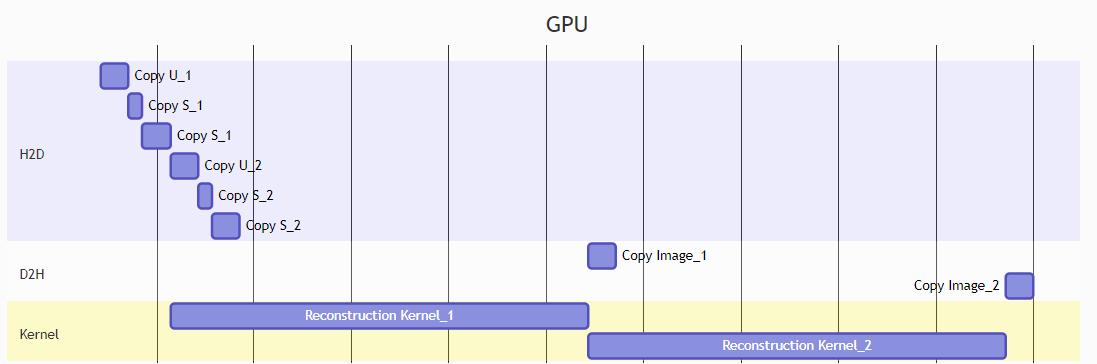

In diesem Diagram ist die Auslastung der verschiedenen Engines zu sehen. Die Matrizen des zweiten Bildes werden parallel geladen, während die Kernel-Funktion ausgeführt wird. Die Kernel-Funktion ist die meiste Zeit ausgelastet. Die D2H und H2D engine ist nur kurz ausgelastet, da die Matrizen nur kurz zurück in den RAM geladen werden müssen, respektive das Bild zurück in den RAM geladen werden muss.

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

---

1a: Vektorisierten Code verwenden: For-Loops sind in Python sehr langsam wie man im ersten Teil sehen kann. 

1b: Kompilierung: Pyhton ist eine interpretierte Programmiersprache. Eine grosse Performance-Steigerung kann erreicht werden, indem der Code kompiliert wird. Dadurch habe ich im ersten Teil einen Speedup von 1500x erreicht. Dies erzielt ähnliche Ergebnisse auf einem ähnlichen Prinzip wie Vektorisierung: C/C++-Code. Denn mit Kompilierung wird hinter den Kulissen C/C++ Code generiert, der viel schneller läuft. Durch Vektorisierung wird im Grunde genommen schon geschriebener Code in C/C++ aus Python angesteuert.

2: Parallelisierung (Multiprocessing): Dadurch können die verschiedenen Kerne der CPU gleichzeitig genutzt werden. So kann jeder Kern ein eigenes Bild rekonstruieren.

3: Heterogeneous Programming: Dadurch wird die Parallelisierung ins extreme getrieben, indem die GPU verwendet wird. Die GPU hat viel mehr Kerne als die CPU und kann auch mit Hilfe ihrem Shared Memory viel schneller arbeiten.

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

---

- Single Instruction Single Data (SISD): Die CPU führt die Rekonstruktion sequentiell aus, das waren alle Varianten aus dem ersten Teil, bis auf 4.3 Threads auf mehreren CPUs. (würden bei den Numba-Funktionen AVX-Instruktionen verwendet werden, wäre es SIMD)
- Single Instruction Multiple Data (SIMD): 
    - Die GPU führt die Rekonstruktion parallel aus, indem sie die Matrizen in mehrere Tiles aufteilt und diese Tiles parallel rekonstruiert. (Der ganze Teil 2)
    - Die CPU führt die Rekonstruktion parallel aus, indem auf jedem CPU-Kern ein anderes Bild rekonstruirt wird. (4.3 Threads auf mehreren CPUs)

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

---

- Compute Bound: Die Rekonstruktion ist ein Compute Bound Problem, da die Rekonstruktion sehr rechenintensiv ist. Das laden der Daten behindert die Auslastung der CPU/GPU nicht stark. (D2H/H2D Engines verbrauchen viel weniger Zeit als die Kernel-Funktion)

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

---

Wenn ich zurück an Kafka denke: ein Producer sendet die Matrizen U, S und V an ein Topic. Mehrere Consumer (einer Consumer Group) lesen die Matrizen und rekonstruieren die Bilder auf einer GPU. Sie senden (als Producer) die rekonstruierten Bilder an ein anderes Topic. Ein weiterer Consumer liest die Bilder und speichert sie auf einer Festplatte (Datasink) oder macht sonst etwas damit.

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

---

- Shared Memory: Durch das Verwenden von Shared Memory kann die GPU mehrmals verwendete Elemente in einen schnelleren Speicher kopieren und von dort schneller darauf zugreifen. Die GPU berechnet sozusagen Submatrix-Multiplikationen (oder bessergesagt Rekonstruktionen) indem sie kleinere Matrizen von $u$ und $vT$ und $s$ ins Shared Memory lädt und dann die Rekonstruktion durchführt.
- Blockgrösse richtig wählen: Die Blockgrösse sollte so gewählt werden, dass die GPU möglichst effizient ausgelastet wird. Das Seitenverhältnis der Blöcke hat einen Einfluss auf die Performance. Ich habe festgestellt, dass ich die beste Performance bei einer Konfiguration von 32x1 erreiche.
- Mit Streams engines parallel auslasten: Die GPU hat zwei Copy-Engines und eine Kernel Engine die theoretisch alle gleichzeitig ausgelastet werden können. Mithilfe von Streams habe ich im Kapitel 6 die Copy-Engines und Kernel Funktion parallel ausgelastet. 
- Memory prefetching: Da das Laden der Daten vom Device Memory ins Shared-Memory immernoch Zeit braucht, kann man sich Memory-Prefetching zu nutze machen. Dabei wird vor dem Berechnen die nächsten Tiles der Matrizen U, s, Vt geladen. CUDA erkennt dann, dass diese Matrizen noch nicht gebraucht werden und kann schonmal die Berechungen durchführen, während es auf die Daten aus dem Device Memory wartet. Dies ist wieder eine Art von Parallelisierung.

- Nur die nötigsten Daten übertragen: Wenn nur die ersten k-Spalten/Zeilen verwendet werden, sollen auch nur die Matrizen bis zu dieser Grösse übertragen werden. Damit kann man Zeit auf den beiden Copy-Engines sparen.

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

---

Ich fand den ersten Teil einfacher, respektive ist dieser für mich besser und mit weniger Zwischenfälle verlaufen. 

Im  ersten Teil habe ich vorallem beim Bonus bei der parallelen Rekonstruktion mit multiproccessing länger gebraucht. Dies, weil multiproccessing in Windows nicht mit interaktiven Python-Instanzen funktioniert, wie dies bei Jupyter-Notebooks der Fall ist.

Im zweiten Teil habe ich bei folgenden Tasks mehr Zeit verbracht:
 - Ich habe zuerst die Kernelfunktion in cupy als C-Code geschrieben und erst später gemerkt, dass dies in Numba wesentlich einfacher geht.
 - Beim Messen der Performance (analysieren welche Block-Grösse am besten ist) habe ich zwischen verschienden Visualisierungen gewechselt, bevor ich mich für eine Entschieden habe.
 - Das Benchmarking der Blockgrössen und Profiling der Kernels nimmt auf meiner GPU wesentlich Zeit in Anspruch. Da ich dies immerwieder getan habe (weil ich mit den Resulaten arbeiten wollte), hat das viel Zeit in Anspruch genommen.
 - Bei der Rekonstruktion von mehreren Bildern gleichzeitig habe ich es nicht fertig gebracht die beiden Coyp-Engines und die Kernel-Engine parallel zu verwenden, trotz mehreren Versuchen.

Ich habe in beiden Mini-Challenges viel über die Beschleunigung von Python Code gelernt. Vorallem habe ich aber die GPU näher kennen gelerent und wie man Kernels schreibt und diese optimiert.

Ich denke das Verständnis wie die GPU läuft könnte man hier noch stärker vertiefen, ich würde dies anhanden der Profilerresultate machen. Ich sehe aber auch, dass dies schwierig ist, wenn man sich noch nicht damit auskennt, und dies deshalb mehr geführt gemacht werden müsste.